In [ ]:
# GENERAL IMPORTS
import cv2
from matplotlib import pyplot as plt
import numpy as np
import glob
import os
from pprint import pprint
# from collections import deque
from time import time
from tqdm import tqdm
import numpy.ma as ma
from functools import partial

# FILE IMPORTS
from config_file import Config

conf = Config()
ROOT_DIR = os.path.dirname(os.path.abspath(os.getcwd()))

results_DL_DIR = os.path.join(ROOT_DIR, "data", "results_DL")

dataset_path = os.path.join(ROOT_DIR, "data", "stereodataset")
folders = glob.glob(os.path.join(dataset_path, "*"))
N_IMAGES = len(folders)

dataset = []

for folder in folders:
    with open(os.path.join(folder, "param_in.txt")) as f:
        params = f.readlines()
        data = {
            "name": os.path.relpath(folder, dataset_path),
            "ref": params[0].split(" ")[1].strip(),
            "gt": params[1].split(" ")[1].strip(),
            "disp_min": int(params[3].split(" ")[1].strip()),
            "disp_max": int(params[4].split(" ")[1].strip()),
            "disp_scale": int(params[5].split(" ")[1].strip()),
            "ignore_border": int(params[7].split(" ")[1].strip()),
        }

        data["result_DL_path"] = os.path.join(results_DL_DIR, data["name"]+".npy")

        data["disp_range"] = range(data["disp_min"], data["disp_max"])
        dataset.append(data)


for data in dataset:
    print(data["result_DL_path"])

def display_img_standard(img):
    if len(img.shape) == 3:
        plt.imshow(img)
    else:
        plt.imshow(img, cmap="gray", vmin=0, vmax=np.max(img))
         

def read_image(path):
    # print("img path {}".format(path))
    img = cv2.imread(path, -1)
    """ print(img.shape)
    plt.figure(figsize=(5,3))
    if len(img.shape) == 2:
        plt.imshow(img, cmap="gray", vmin=0, vmax=255)
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show() """
    return img


def evaluation_dense(gt, prediction, disp_scale, ignore_border=0):
    '''
    Better when LOWER
    eval = mean "correctness", where correctness of a disparity measure is 0 if the error is <= 1, 1 otherwise
    '''
    # reduce the gt disparity_map by its scale
    gt = gt/float(disp_scale)

    # prediction = (prediction-np.min(prediction))
    # prediction = (prediction+np.min(gt))/np.max(prediction)*(np.max(gt)-np.min(gt))

    print(np.min(gt), np.max(gt), np.mean(gt), np.std(gt))
    print(np.min(prediction), np.max(prediction), np.mean(prediction), np.std(prediction))

    # prediction = pad_to_img_size(gt, prediction)
    h, w = gt.shape[:2]
    b = ignore_border
    difference = np.abs(gt[b:h-b+1, b:w-b+1] - prediction[b:h-b+1, b:w-b+1]) - 1 # min_value is -1
    
    difference = np.minimum(difference, 1) # cap the image to max_value = 1
    difference = np.maximum(difference, 0) # cap the image to min_value = 0
    plt.imshow(difference, cmap="gray", vmin=0, vmax=1)
    return 1-np.mean(difference)

/Users/marcelloceresini/github/ComputerVision/data/results_DL/sawtooth.npy
/Users/marcelloceresini/github/ComputerVision/data/results_DL/tsukuba.npy
/Users/marcelloceresini/github/ComputerVision/data/results_DL/venus.npy
/Users/marcelloceresini/github/ComputerVision/data/results_DL/map.npy


In [ ]:
for i, data in enumerate(dataset):
    print(data["name"])

    left_img_full_path = os.path.join(folders[i], data["ref"])
    data["left_img"] = read_image(left_img_full_path)

    left_img_path = data["ref"]
    init_char = left_img_path[0]
    extension = left_img_path.split(".")[-1]
    right_img_format = init_char + "*." + extension
    right_img_path = glob.glob(os.path.join(folders[i], right_img_format))
    right_img_path.remove(left_img_full_path)
    if len(right_img_path) > 1:
        raise ValueError("Too many images with format {}".format(right_img_format))
    else:
        right_img_path = right_img_path[0]

    data["right_img"] = read_image(right_img_path)
    
    data["disp_map_gt"] = read_image(os.path.join(folders[i], data["gt"]))
    data["DL_pred"] = cv2.flip(np.load(data["result_DL_path"]), 1)


sawtooth
tsukuba
venus
map


sawtooth
3.875 17.875 9.993770464467621 4.784457965308516
2.8334205 20.148018 10.042707 4.76684
Accuracy 99.22%


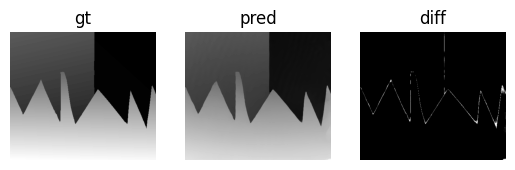

tsukuba
0.0 14.0 5.381655092592593 3.6364600513566696
3.712995 18.212809 6.564597 2.5277793
Accuracy 95.97%


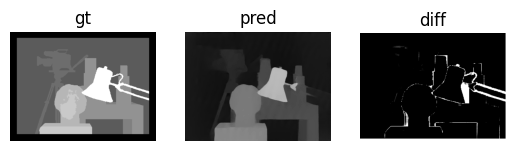

venus
3.0 19.25 8.853179783662812 4.006487854095155
3.4801273 19.35231 8.891838 3.946843
Accuracy 99.62%


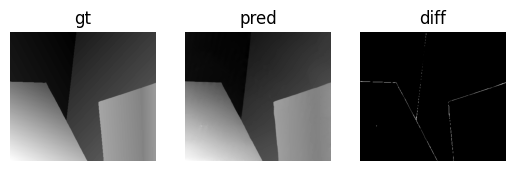

map
4.375 28.125 11.884012698878456 9.9529065470267
3.7969785 28.368172 11.881341 9.979418
Accuracy 98.84%


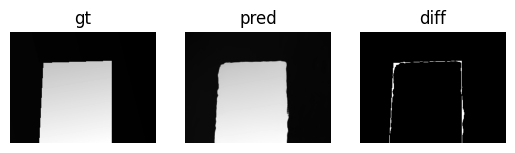

Tot acc = 98.42%


In [ ]:
acc=0
for data in dataset:
    print(data["name"])
    gt = data["disp_map_gt"]
    # gt = data["disp_map_gt"]/data["disp_scale"]
    pred = np.abs(data["DL_pred"])

    plt.subplot(131)
    plt.axis("off")
    plt.title("gt")
    plt.imshow(gt, cmap="gray")
    plt.subplot(132)
    plt.axis("off")
    plt.title("pred")
    plt.imshow(pred, cmap="gray")
    plt.subplot(133)
    plt.axis("off")
    plt.title("diff")
    
    accuracy = evaluation_dense(gt, pred, data["disp_scale"], data["ignore_border"])

    print("Accuracy {:.2f}%".format(accuracy*100))
    plt.show()
    acc += accuracy
9
print("Tot acc = {:.2f}%".format(acc/4*100))

